# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(22, 22)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [8]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [12]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [13]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [14]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [15]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,174031.0,3.626304e+05
1,422270.0,8.127672e+06
2,353042.0,2.284319e+06
3,376975.0,1.442860e+06
4,173895.0,3.882500e+05
5,422181.0,1.593914e+07
6,352863.0,3.070318e+06
7,376872.0,2.752511e+06
8,69912.0,1.646669e+07


Text(0.5, 1.0, 'transaction count by tick')

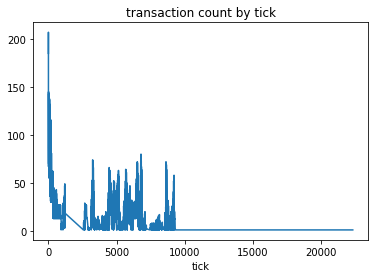

In [16]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

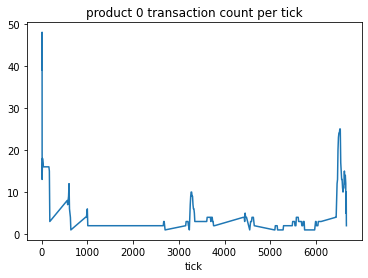

In [17]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

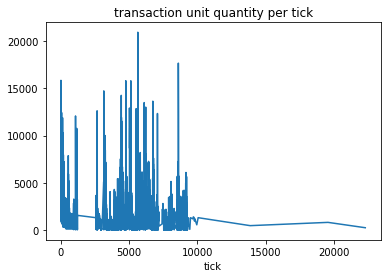

In [18]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

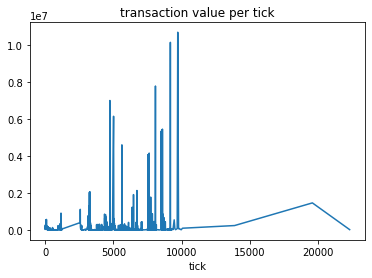

In [19]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

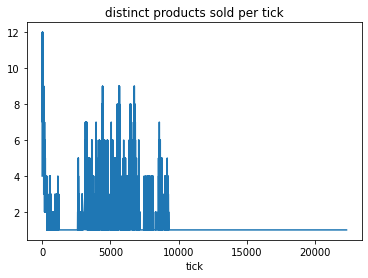

In [20]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

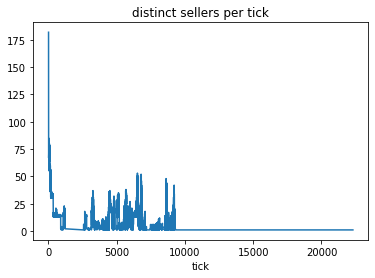

In [21]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

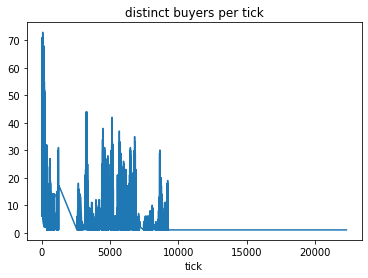

In [22]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [23]:
transaction_df["seller"].nunique()

296

In [24]:
transaction_df["buyer"].nunique()

118

In [25]:
transaction_df["product"].nunique()

19

<AxesSubplot:>

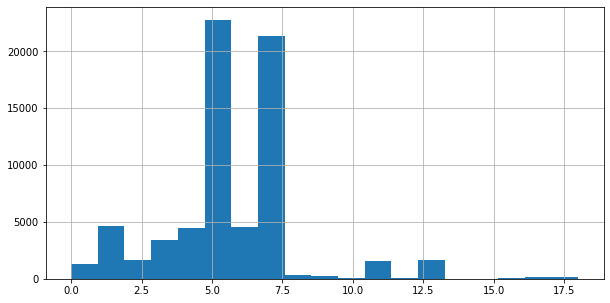

In [26]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

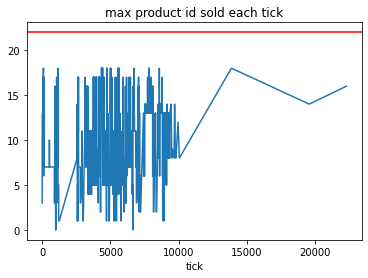

In [27]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [28]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    2075.000000
mean        3.934561
std         1.625484
min         1.287740
25%         2.138805
50%         4.830534
75%         5.245177
max         5.893374
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

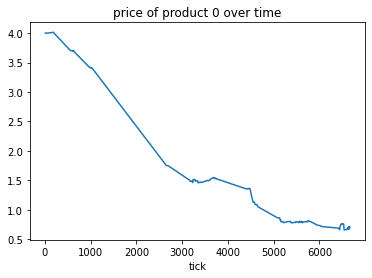

In [29]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

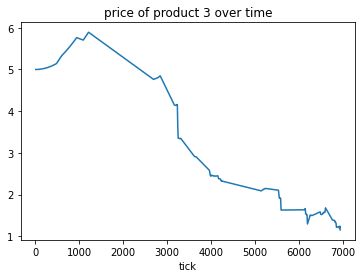

In [30]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

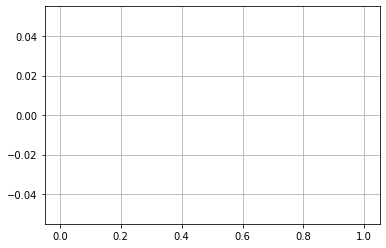

In [31]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

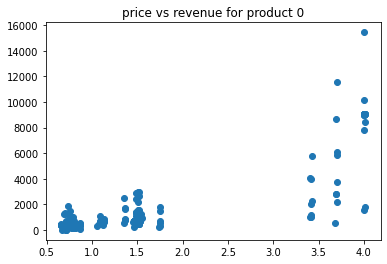

In [32]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

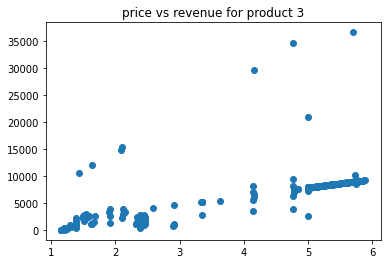

In [33]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [34]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value


In [35]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
0,6665,2.005158,174031.0,3.626304e+05
1,9226,19.011459,422270.0,8.127672e+06
2,8666,6.798620,353042.0,2.284319e+06
3,6935,3.734992,376975.0,1.442860e+06
4,7021,2.633408,173895.0,3.882500e+05
5,9258,46.599323,422181.0,1.593914e+07
6,9171,19.660557,352863.0,3.070318e+06
7,7081,8.472910,376872.0,2.752511e+06
8,10061,242.628876,69912.0,1.646669e+07


## Transaction Graph

In [36]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,4,0,4091.0
1,4,35,567.0
2,4,37,159.0
3,4,47,165.0
4,4,58,242.0
...,...,...,...
2314,298,235,31.0
2315,298,245,88.0
2316,298,247,99.0
2317,298,252,99.0


In [37]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [38]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [39]:
G = nx.relabel_nodes(G, labels)

In [40]:
nx.is_directed_acyclic_graph(G)

True

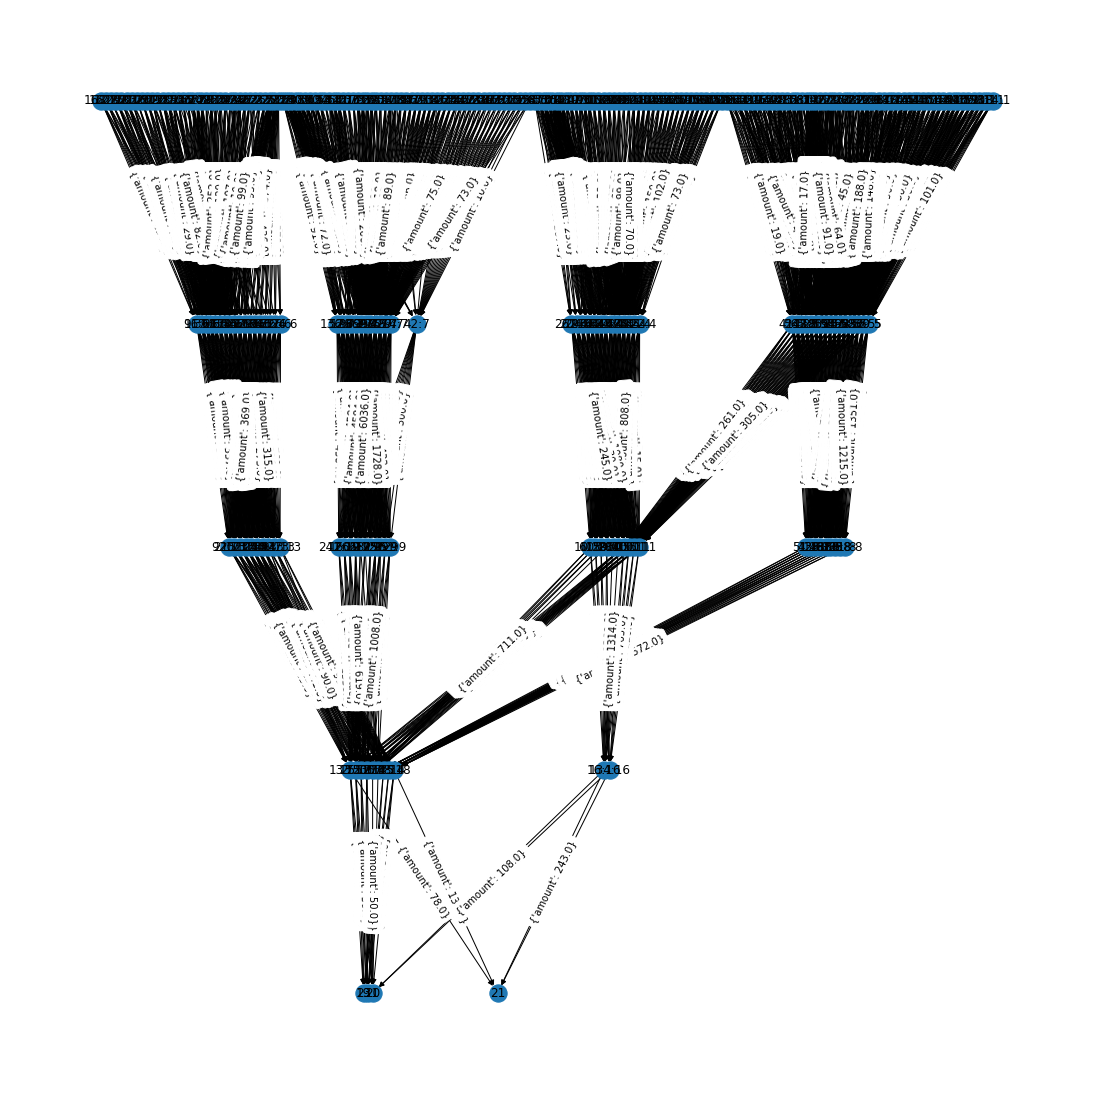

In [41]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

# Balance

In [42]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,577.821568
1,0,6249.140109
2,0,2182.942444
3,0,710.714268
4,0,3750.000000
...,...,...
295,0,577.821568
296,0,3750.000000
297,0,577.821568


In [43]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,50000,1.273365
1,50000,18.643005
2,50000,4.097479
3,50000,3.683008
4,50000,3982.667297
...,...,...
295,50000,0.884798
296,50000,3335.841953
297,50000,1.358268


In [44]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [45]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    3.000000e+02
mean     1.647123e+07
std      2.491363e+08
min      5.778216e+02
25%      7.107143e+02
50%      6.000000e+03
75%      2.730000e+04
max      4.305772e+09
Name: balance, dtype: float64

In [46]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    3.000000e+02
mean     1.645667e+07
std      2.455706e+08
min      7.158314e-01
25%      2.625556e+00
50%      1.144068e+01
75%      5.934391e+04
max      4.248511e+09
Name: balance, dtype: float64

In [47]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

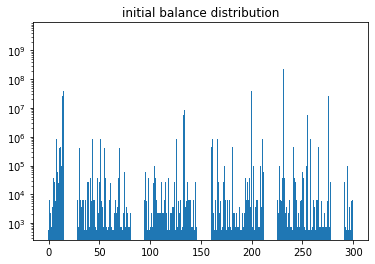

In [48]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

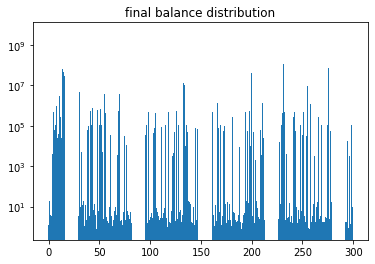

In [49]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [50]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0        -576.548204
1       -6230.497104
2       -2178.844965
3        -707.031260
4         232.667297
           ...      
295      -576.936770
296      -414.158047
297      -576.463300
298    100548.737941
299     -6239.430105
Name: balance, Length: 300, dtype: float64

In [51]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0           1.273365
1          18.643005
2           4.097479
3           3.683008
4        3982.667297
           ...      
295         0.884798
296      3335.841953
297         1.358268
298    106548.737941
299         9.710004
Name: balance, Length: 300, dtype: float64

In [52]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1500000,0,50000,1.273365e+00
1500001,1,50000,1.864301e+01
1500002,2,50000,4.097479e+00
1500003,3,50000,3.683008e+00
1500004,4,50000,3.982667e+03
1500005,5,50000,5.030866e+05
1500006,6,50000,6.203790e+04
1500007,7,50000,1.043728e+05
1500008,8,50000,1.013000e+06
1500009,9,50000,2.624175e+04


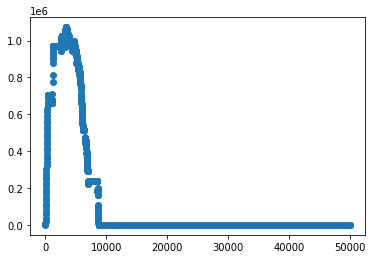

In [142]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [54]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [55]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,0.002204
1,0.002983
2,0.001877
3,0.005182
4,1.062045
...,...
295,0.001531
296,0.889558
297,0.002351


# Inventory

## Last Tick Inventory

In [56]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
1500000,0,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500001,1,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500002,2,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500003,3,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500004,4,50000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500295,295,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500296,296,50000,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500297,297,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500298,298,50000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [57]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,tick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [58]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [59]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [60]:
agent_id = 17
inv_s = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,NaN
9,42.0,8.0,48.0,-6.0,0.875000


In [61]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == balance_df["tick"].max())]

,agent,tick,balance
1500017,17,50000,1.533174e+07


In [62]:
buy_budget_df[(buy_budget_df["tick"] == buy_budget_df["tick"].max()) & (buy_budget_df["agent"] == agent_id)].T

,1500017
agent,1.700000e+01
tick,5.000000e+04
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00


In [63]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    5001.000000
mean        1.427714
std         8.908671
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        72.000000
Name: 17, dtype: float64

# Buy and Sell Prices

In [64]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     2.217843e+00
1     2.008599e+01
2     6.705756e+00
3     3.928573e+00
4     9.229374e-01
5     5.242306e+00
6     1.448427e+00
7     1.425896e+00
8     4.218678e+01
9     6.407710e+00
10    9.355122e+00
11    3.656072e+02
12    8.879562e-05
13    1.794925e+01
14    5.413250e+02
15    1.587200e+04
16    2.580062e+03
17    9.922380e+03
18    1.255482e+03
19    4.369956e+06
20    1.501225e+08
21    2.330774e+05
dtype: float64

## Market Analysis for one Good

In [65]:
#dfsp[dfsp[f'{product_id}_inventory'] == 0][product_id] = np.inf


In [126]:
product_id = 1
min_ticks = 0
max_ticks = np.inf

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [127]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
1,5001.0,18.685557,5.121757,2.315859,20.085989,20.085989,20.085989,43.0
24,5001.0,18.596283,5.250613,2.148281,20.085989,20.085989,20.085989,43.0
27,5001.0,18.678446,5.132142,2.301984,20.085989,20.085989,20.085989,43.0
28,5001.0,18.674889,5.137330,2.295078,20.085989,20.085989,20.085989,43.0
31,5001.0,18.646380,5.178711,2.240571,20.085989,20.085989,20.085989,43.0
33,5001.0,18.624941,5.209607,2.200542,20.085989,20.085989,20.085989,43.0
34,5001.0,18.614204,5.225010,2.180797,20.085989,20.085989,20.085989,43.0
36,5001.0,18.610623,5.230137,2.174254,20.085989,20.085989,20.085989,43.0
44,5001.0,18.607040,5.235261,2.167732,20.085989,20.085989,20.085989,43.0


Buyer Prices

In [128]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
5,4316.0,13008.507606,30395.544283,7.174634,30.981558,261.919488,6630.544403,167853.467786
22,4288.0,6166.885188,14326.486051,8.053291,31.825613,144.568214,3183.913730,78928.871023
41,4397.0,6742.286392,15905.194690,7.964493,27.361667,131.865864,3291.049762,88523.757233
48,4436.0,9398.787635,22307.958112,8.062915,27.038240,162.434369,4498.702656,124593.793817
56,4266.0,5965.450027,13814.525209,7.961177,33.730828,145.288868,3114.669214,75950.633055
69,4323.0,20147.651693,47136.066417,7.531084,32.193946,402.184158,10234.899332,260460.108337
83,4338.0,20995.128328,49220.443188,7.505159,30.955454,411.220179,10583.051835,272362.420749
85,4280.0,6224.000156,14444.793358,7.945123,31.421642,143.483483,3226.984791,79518.769611
98,4312.0,18444.120893,43083.762331,7.554791,31.499241,373.328948,9422.629347,237822.152238


26342.0


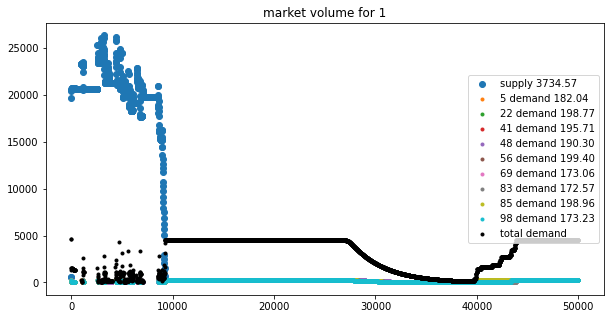

In [129]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [130]:
seller_df[seller_df > 0].index.to_series().describe()

count     923.000000
mean     4610.000000
std      2665.914477
min         0.000000
25%      2305.000000
50%      4610.000000
75%      6915.000000
max      9220.000000
Name: tick, dtype: float64

In [131]:
seller_df.describe()

count     5001.000000
mean      3734.571686
std       7950.175574
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26342.000000
Name: 1, dtype: float64

In [132]:
buyer_df.groupby("agent")["units"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
5,4316.0,182.040547,108.051249,2.0,57.00,264.0,264.0,270.0
22,4288.0,198.772155,101.711040,5.0,85.00,267.0,267.0,270.0
41,4397.0,195.712531,102.262553,3.0,79.00,267.0,267.0,270.0
48,4436.0,190.299594,104.164633,4.0,69.00,266.0,266.0,270.0
56,4266.0,199.404360,101.541093,4.0,87.25,267.0,267.0,270.0
69,4323.0,173.061763,110.961459,1.0,47.00,263.0,263.0,270.0
83,4338.0,172.568695,110.977569,1.0,48.00,263.0,263.0,270.0
85,4280.0,198.955841,101.625959,3.0,85.75,267.0,267.0,270.0
98,4312.0,173.234462,110.950778,1.0,47.00,263.0,263.0,270.0


In [133]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
5,5001.0,16803.281344,13300.322219,0.0,3490.0,15990.0,28490.0,40990.0
22,5001.0,16663.933213,13261.701186,0.0,3320.0,15820.0,28320.0,40820.0
41,5001.0,16666.064787,13259.041131,0.0,3320.0,15820.0,28320.0,40820.0
48,5001.0,16657.448510,13257.302024,0.0,3310.0,15810.0,28310.0,40810.0
56,5001.0,16663.937213,13261.696148,0.0,3320.0,15820.0,28320.0,40820.0
69,5001.0,16811.539692,13302.522851,0.0,3500.0,16000.0,28500.0,41000.0
83,5001.0,16811.567686,13302.487667,0.0,3500.0,16000.0,28500.0,41000.0
85,5001.0,16664.561088,13260.917512,0.0,3320.0,15820.0,28320.0,40820.0
98,5001.0,16803.303339,13300.294412,0.0,3490.0,15990.0,28490.0,40990.0


/tmp/ipykernel_1684687/3739909283.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")


Text(0.5, 1.0, 'price chart for 1')

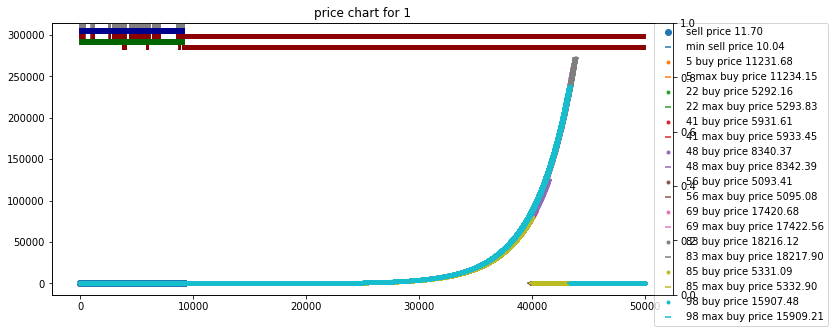

In [134]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
# is there a transaction?
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
# do the sellers have inventory?
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
# do the buyers demand goods?
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
# are prices compatible?
ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")
# is at least one agent in the cannot buy state (> 100 ticks)
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [135]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
5,5001.0,16803.281344,13300.322219,0.0,3490.0,15990.0,28490.0,40990.0
22,5001.0,16663.933213,13261.701186,0.0,3320.0,15820.0,28320.0,40820.0
41,5001.0,16666.064787,13259.041131,0.0,3320.0,15820.0,28320.0,40820.0
48,5001.0,16657.448510,13257.302024,0.0,3310.0,15810.0,28310.0,40810.0
56,5001.0,16663.937213,13261.696148,0.0,3320.0,15820.0,28320.0,40820.0
69,5001.0,16811.539692,13302.522851,0.0,3500.0,16000.0,28500.0,41000.0
83,5001.0,16811.567686,13302.487667,0.0,3500.0,16000.0,28500.0,41000.0
85,5001.0,16664.561088,13260.917512,0.0,3320.0,15820.0,28320.0,40820.0
98,5001.0,16803.303339,13300.294412,0.0,3490.0,15990.0,28490.0,40990.0


<AxesSubplot:xlabel='tick'>

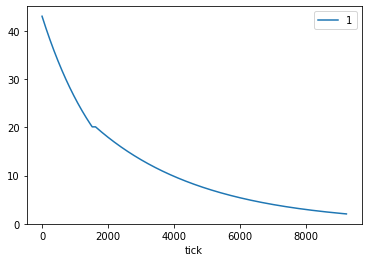

In [136]:
df1.plot()

(0.0, 652542.8325768139)

<Figure size 432x288 with 0 Axes>

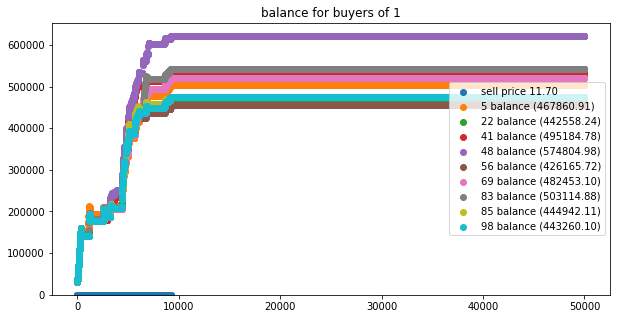

In [137]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [77]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
5      25470.0
22     22410.0
41     31842.0
48     35937.0
56     20250.0
69     26055.0
83     26811.0
85     21213.0
98     24561.0
105    20871.0
118    21717.0
194    25713.0
198    25884.0
230    24102.0
232    23184.0
242    21807.0
251    24354.0
Name: amount, dtype: float64

Total Amount Purchased

In [78]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
8       37826.0
11      10179.0
30      25859.0
43      38722.0
51      12637.0
55      20031.0
70      16173.0
126     17412.0
148    136317.0
161     21108.0
166     27944.0
211     30357.0
258     27616.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [79]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
8,2615.0,4428.055832,2728.908676,12.0,338.00,5668.0,5888.0,8660.0
11,624.0,3273.267628,1752.996789,21.0,3267.00,3490.0,5141.0,5161.0
30,873.0,4320.587629,2743.341794,28.0,1217.00,4629.0,6791.0,7051.0
43,2451.0,4842.752346,3476.025603,31.0,319.00,5821.0,6800.0,9250.0
51,1208.0,2665.883278,2814.290318,41.0,148.00,326.0,5857.0,5880.0
55,830.0,3683.624096,1793.177642,51.0,3275.00,3771.5,5471.0,5791.0
70,1114.0,3969.395871,1221.716668,58.0,3321.00,3760.0,4655.0,6111.0
126,678.0,530.734513,786.617507,61.0,90.25,160.0,250.0,3261.0
148,5260.0,5443.558365,2606.173086,71.0,4857.00,5736.0,6823.0,9258.0


Prices Paid

In [80]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
8,2615.0,46.618112,28.151603,10.556108,19.438048,31.897957,82.205000,90.738831
11,624.0,35.460072,24.440056,13.363891,16.647083,22.592929,37.461536,82.411025
30,873.0,47.552237,21.244851,23.143516,33.629531,37.825916,47.664698,85.269585
43,2451.0,41.582341,33.103371,7.136078,17.746441,19.828662,85.269578,90.986985
51,1208.0,57.503849,33.458794,18.977499,19.464647,83.053783,88.169882,90.716787
55,830.0,31.941578,22.287138,13.409968,19.361012,21.730404,34.011084,83.377690
70,1114.0,22.295694,15.176694,13.477184,14.247365,16.093482,27.730391,83.377690
126,678.0,81.345345,11.154489,34.668914,83.619615,85.955744,87.803589,88.419537
148,5260.0,30.860672,23.670588,7.417212,18.652610,26.315448,27.783346,88.775862


## Buy/Sell Price Investigation

In [81]:
df1[product_id].describe()

count    924.000000
mean      23.610401
std       22.027383
min        5.195154
25%       10.295947
50%       12.961291
75%       30.411043
max       87.235349
Name: 5, dtype: float64

In [82]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,5001.0,1168.788527,2664.351424,11.768384,42.287814,115.007686,747.842257,15829.264987
11,5001.0,33.891865,4.824731,13.063396,33.547440,33.547440,33.547440,82.822050
30,5001.0,74.567920,13.875821,22.294139,79.688927,79.688927,79.688927,87.057602
43,5001.0,876.633075,1943.912336,9.029849,34.640113,95.234845,612.595878,11571.492103
51,5001.0,1003.659166,2073.510181,14.288056,48.501350,131.511740,855.160557,12336.131284
55,5001.0,22.602626,6.260694,12.941068,21.060055,21.060055,21.060055,84.070603
70,5001.0,23.149247,5.897098,13.310241,21.985610,21.985610,21.985610,84.070623
126,5001.0,916.480122,1998.297315,10.215690,52.117116,104.735202,681.045004,11900.544867
148,5001.0,5853.611649,14848.533702,9.282175,35.519573,100.737792,2062.883427,87224.996847


In [83]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

2501.2715405634926

In [84]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

count    924.000000
mean      66.663819
std       20.311455
min        0.822050
25%       64.823803
50%       72.672382
75%       80.357570
max       86.864336
Name: 5, dtype: float64

In [85]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

2501.194701391415

In [86]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

count    924.000000
mean     146.421270
std       78.785806
min       68.470339
25%       75.752753
50%      147.703288
75%      165.491197
max      525.151058
Name: 5, dtype: float64

In [87]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
5,43.000000,82.000000,82.000000,43.000000,39.000000
305,43.215000,82.000000,82.000000,43.000000,38.785000
605,43.431075,82.205000,82.000000,43.000000,38.568925
905,43.648230,82.411025,82.410000,43.001074,38.761770
1205,43.866472,82.823080,82.455226,43.003214,38.588754
...,...,...,...,...,...
1498805,72.899052,72.899052,5.310418,5.310418,-67.588634
1499105,73.117749,73.117749,5.310418,5.310418,-67.807332
1499405,73.337102,73.337102,5.310418,5.310418,-68.026685
1499705,73.557114,73.557114,5.310418,5.310418,-68.246696


## Larger Scale Market Analysis

In [88]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [89]:
demand_units_df.shape

(1500300, 22)

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [90]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
0      7.803731
1     18.935025
2     15.830770
3     16.903950
4      7.797632
5     18.931034
6     15.822743
7     16.899332
8      3.134927
9      0.818439
10     0.545222
11     1.012152
12     0.819201
13     2.258374
14     0.206269
15     0.006726
16     0.100489
17     0.058652
18     0.134792
Name: amount, dtype: float64

In [91]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,agents,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,39.0,2736.399320,11.023742,3151.739852,0.658504,-415.340532,0.000000
1,55.0,3734.571686,6.221580,2707.441112,0.706820,1027.130574,0.000000
2,37.0,5052.044791,7.883380,6439.590682,0.680487,-1387.545891,0.000000
3,51.0,2169.648670,9.225962,2773.210358,0.675281,-603.561688,0.000000
4,15.0,2033.641872,11.312336,9545.017397,0.380407,-7511.375525,-415.340532
5,17.0,1616.571886,9.359193,12645.842631,0.746662,-11029.270746,1027.130574
6,18.0,4660.409518,9.304094,7365.513097,0.759642,-2705.103579,-1387.545891
7,13.0,1170.832833,12.489864,22969.954209,0.749629,-21799.121376,-603.561688
8,9.0,1867.887423,12.651058,6288.405719,1.037049,-4420.518296,-2205.854149
9,6.0,979.003199,16.987064,5274.627275,1.885976,-4295.624075,-5449.780344


In [92]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0      -415.340532
1      1027.130574
2     -1387.545891
3      -603.561688
4     -7926.716057
5    -10002.140172
6     -4092.649470
7    -22402.683063
8     -6626.372446
9     -9745.404419
10    -7103.013757
11   -17404.275612
12     4245.362613
13   -10334.874282
14    -1102.588632
15   -14968.574152
16   -12165.908618
17    -4421.446511
18    -5768.031027
19       14.728927
20      -14.072984
21    -2533.080584
dtype: float64

In [93]:
pd.DataFrame(production_chain.adj_matrix)[11]

0     0.0
1     0.0
2     0.0
3     0.0
4     5.0
5     3.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
Name: 11, dtype: float64

## Cannot Buy or Sell

In [94]:
cannot_buy_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    1.500300e+06
mean     6.119933e+03
std      1.114044e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.580000e+03
max      4.985000e+04
dtype: float64

In [95]:
cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    1.500300e+06
mean     5.214723e+02
std      2.644880e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.622000e+04
dtype: float64

What product was being sold by the agent with the largest cannot sell ticks?

In [96]:
agent_goods_df.loc[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).index[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).argmax()][1]]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    1.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
Name: 241, dtype: float64

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [97]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [98]:
costs.describe()

count    3.000000e+02
mean     9.394876e+05
std      7.197666e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.074859e+05
max      1.031837e+08
Name: value, dtype: float64

In [99]:
revenue.describe()

count    3.000000e+02
mean     9.394876e+05
std      4.868803e+06
min      0.000000e+00
25%      2.509013e+03
50%      8.322428e+03
75%      1.961251e+05
max      5.257462e+07
Name: value, dtype: float64

Profit (without accounting for inventory value):

In [100]:
(revenue-costs).describe()

count    3.000000e+02
mean     4.967054e-11
std      8.374848e+06
min     -1.031837e+08
25%      8.313585e+02
50%      4.032073e+03
75%      2.817732e+04
max      4.983958e+07
Name: value, dtype: float64

How much value is sitting in inventory?

In [101]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

count    3.000000e+02
mean     1.603493e+05
std      1.692893e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.593125e+01
max      2.654812e+07
dtype: float64

In [102]:
revenue.mean() - costs.mean()

2.3283064365386963e-10

In [103]:
value_of_goods_on_hand.mean()/revenue.mean()

0.17067736107206022

Profit (accounting for value of goods on hand):

In [104]:
((revenue - costs) + value_of_goods_on_hand)

seller
0      2.439761e+05
1      4.880892e+06
2      1.279258e+06
3      9.708763e+05
4      2.383490e+02
           ...     
295    8.092152e+02
296   -4.070560e+02
297    7.919459e+02
298    1.005499e+05
299    2.839437e+03
Length: 300, dtype: float64

<AxesSubplot:>

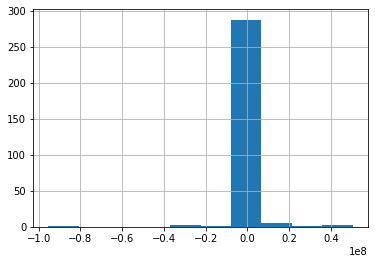

In [105]:
((revenue - costs) + value_of_goods_on_hand).hist()

## Further Investigation

### Who Made a Profit?

In [106]:
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  14,  15,
         16,  17,  18,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  44,  45,
         46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  93,  94,  96,  97,  98,  99, 100, 101,
        102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 123, 124, 125, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157,
        158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195

In [107]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

seller
276    5.257462e+07
18     4.158329e+07
14     4.006333e+07
16     2.524840e+07
17     1.274305e+07
15     9.242560e+06
133    9.011370e+06
153    8.678708e+06
148    5.333359e+06
30     5.168460e+06
Name: value, dtype: float64

In [108]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

buyer
18     1.328248e+07
16     5.026202e+06
17     3.297012e+06
148    3.284801e+06
276    2.735035e+06
           ...     
129    0.000000e+00
130    0.000000e+00
131    0.000000e+00
132    0.000000e+00
299    0.000000e+00
Name: value, Length: 265, dtype: float64

top profit takers

In [109]:
(revenue-costs).sort_values(ascending=False).head(20)

seller
276    4.983958e+07
14     3.798568e+07
18     2.830081e+07
16     2.022220e+07
17     9.446036e+06
15     7.788528e+06
133    7.347864e+06
153    6.963521e+06
1      4.880892e+06
30     4.115980e+06
255    3.406693e+06
70     3.372368e+06
55     3.165051e+06
11     2.770402e+06
24     2.647844e+06
148    2.048559e+06
134    1.977387e+06
2      1.279258e+06
3      9.708763e+05
23     7.693740e+05
Name: value, dtype: float64

In [110]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

276    14
14     14
18     18
16     16
17     17
15     15
133    17
153    17
1       1
30     11
255    17
70     11
55     11
11     11
24      1
148     8
134    16
2       2
3       3
23      2
dtype: int64

Taking into account value of goods on hand:

In [111]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

seller
276    5.049254e+07
14     3.802060e+07
18     2.830771e+07
16     2.022677e+07
17     9.717529e+06
15     7.894225e+06
133    7.438976e+06
153    7.007571e+06
1      4.880892e+06
30     4.124816e+06
134    4.034904e+06
255    3.474908e+06
70     3.381740e+06
55     3.173891e+06
11     2.779922e+06
24     2.647844e+06
148    2.049019e+06
2      1.279258e+06
3      9.708763e+05
200    9.307088e+05
dtype: float64

In [112]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

276    14
14     14
18     18
16     16
17     17
15     15
133    17
153    17
1       1
30     11
134    16
255    17
70     11
55     11
11     11
24      1
148     8
2       2
3       3
200    15
dtype: int64

### Who Made a Loss?

And selling what products?

In [113]:
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

(array([  9,  12,  13,  19,  20,  21,  43,  51,  75,  92,  95, 104, 122,
        126, 151, 160, 161, 181, 202, 204, 209, 210, 212, 215, 227, 231,
        241, 250, 254, 262, 266, 280, 284, 294, 296]),)

In [114]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

9       9
12     12
13     13
19     19
20     20
21     21
43      8
51      8
75      9
92     13
95      9
104    13
122     4
126     8
151     9
160    12
161     8
181    12
202    13
204     4
209    13
210     4
212     9
215    13
227    13
231    19
241    12
250     9
254    13
262     4
266    12
280    10
284    10
294    13
296     4
dtype: int64

### Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [115]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0        -576.548204
1       -6230.497104
2       -2178.844965
3        -707.031260
4         232.667297
           ...      
295      -576.936770
296      -414.158047
297      -576.463300
298    100548.737941
299     -6239.430105
Name: balance, Length: 300, dtype: float64

<AxesSubplot:>

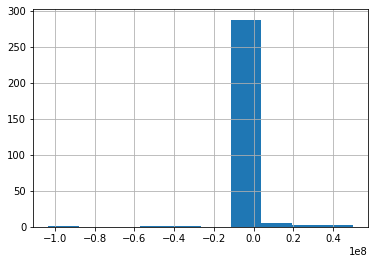

In [116]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

<AxesSubplot:>

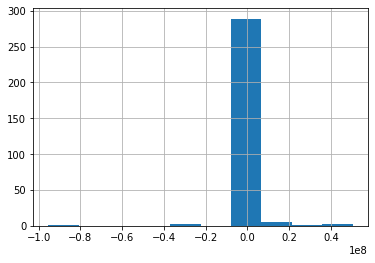

In [117]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

# Production Efficiency